# Second-Hand Car Price Estimation

The Rusty Bargain used car sales service is developing an application to attract new customers. With this app, you can quickly find out the market value of your car. You have access to the history: technical specifications, equipment versions, and prices. You need to create a model that determines the market value.
Rusty Bargain is interested in:
- The quality of the prediction.
- The speed of the prediction.
- The training time required.

# Initialization

In [531]:
# Load libraries

# Data manipulation
import math
import itertools
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Modeling
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

In [532]:
# Load the data into a DataFrame
df = pd.read_csv('../datasets/car_data.csv')

In [533]:
# Print the general/summary information about the DataFrame
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
166505,05/03/2016 19:54,2000,wagon,1998,manual,90,caddy,150000,3,gasoline,volkswagen,no,05/03/2016 00:00,0,4249,12/03/2016 07:46
216110,09/03/2016 01:37,0,wagon,1992,auto,150,omega,150000,12,petrol,opel,NaN,09/03/2016 00:00,0,38315,12/03/2016 16:49
220635,25/03/2016 08:54,2500,small,2005,manual,75,2_reihe,150000,10,lpg,peugeot,no,25/03/2016 00:00,0,50827,06/04/2016 07:46
242449,14/03/2016 22:06,3500,small,2006,manual,131,other,150000,10,gasoline,fiat,no,14/03/2016 00:00,0,65589,16/03/2016 17:30
43760,07/03/2016 22:36,2400,coupe,2004,manual,82,megane,150000,11,petrol,renault,no,07/03/2016 00:00,0,87700,05/04/2016 18:45


# Prepare data

In [534]:
# Select the columns that will be used
chosen_columns = [
    "Price",
    "VehicleType",
    "RegistrationYear",
    "Gearbox",
    "Power",
    "Model",
    "Mileage",
    "FuelType",
    "Brand",
    "NotRepaired"
]

# Create a new DataFrame with the selected columns
df = df[chosen_columns]

# Parse values of the column "NotRepaired" to boolean
df["NotRepaired"] = df["NotRepaired"].replace({"yes": True, "no": False})

In [535]:
# Print the general/summary information about the DataFrame
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Mileage           354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
89936,899,wagon,1996,manual,116,3er,150000,petrol,bmw,False
287865,4200,sedan,2004,manual,105,golf,150000,gasoline,volkswagen,False
95437,500,small,1993,manual,60,corsa,150000,petrol,opel,False
254936,9000,sedan,2005,manual,215,a6,150000,gasoline,audi,False
202805,1000,sedan,1990,manual,109,other,150000,petrol,mercedes_benz,False


In [536]:
# Get rid of the records with missing values on "Model" column
df = df.dropna(subset=["Model"])

# Get rid of the records with missing values on "VehicleType" column
df = df.dropna(subset=["VehicleType"])

# Get rid of the records with missing values on "Gearbox" column
df = df.dropna(subset=["Gearbox"])

# Get rid of the records with missing values on "FuelType" column
df = df.dropna(subset=["FuelType"])

# Impute missing values on "NotRepaired" column with "no", considering that they are second-hand cars
df["NotRepaired"] = df["NotRepaired"].fillna(False).astype("uint8")

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [537]:
# Print the general/summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284126 entries, 0 to 284125
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             284126 non-null  int64 
 1   VehicleType       284126 non-null  object
 2   RegistrationYear  284126 non-null  int64 
 3   Gearbox           284126 non-null  object
 4   Power             284126 non-null  int64 
 5   Model             284126 non-null  object
 6   Mileage           284126 non-null  int64 
 7   FuelType          284126 non-null  object
 8   Brand             284126 non-null  object
 9   NotRepaired       284126 non-null  uint8 
dtypes: int64(4), object(5), uint8(1)
memory usage: 19.8+ MB


## Intermediate Conclusion

The `Model` column is of great importance for data imputation because the model of a car can be a good indicator of its different characteristics. Therefore, it was decided to use this column as the basis for imputing some columns with missing values, and records that did not have this data were also removed.

The missing values in the `NotRepaired` column were filled with "no" since this value is the mode, and there is a high probability that a used car has had repairs.

**NOTE:** It should be mentioned that the `Power` column contains a considerable number of zero values.

In [538]:
# Explore values on the "VehicleType" column
df["VehicleType"].value_counts()

sedan          83020
small          70089
wagon          58946
bus            26372
convertible    18193
coupe          14337
suv            10686
other           2483
Name: VehicleType, dtype: int64

In [539]:
# Explore values on the "Gearbox" column
df["Gearbox"].value_counts()

manual    226192
auto       57934
Name: Gearbox, dtype: int64

In [540]:
# Explore values on the "FuelType" column
df["FuelType"].value_counts()

petrol      189857
gasoline     88809
lpg           4617
cng            492
hybrid         191
other          101
electric        59
Name: FuelType, dtype: int64

In [541]:
# Only keep the 20 most frequent values on the "Model" column and replace the rest with "other"
df.loc[~df["Model"].isin(df["Model"].value_counts().head(20).index), "Model"] = "other"

# Explore values on the "Model" column
df["Model"].value_counts()

other          136439
golf            23569
3er             17398
polo            10584
corsa           10048
astra            8920
a4               8773
passat           8757
c_klasse         7485
5er              7178
e_klasse         6134
a3               5015
focus            5004
a6               5004
fiesta           4759
2_reihe          4313
transporter      4107
twingo           3820
vectra           3445
a_klasse         3374
Name: Model, dtype: int64

In [542]:
# Only keep the 20 most frequent values on the "Brand" column and replace the rest with "other"
df.loc[~df["Brand"].isin(df["Brand"].value_counts().head(20).index), "Brand"] = "other"

# Explore values on the "Brand" column
df["Brand"].value_counts()

volkswagen       60598
bmw              31248
opel             31020
mercedes_benz    27312
audi             24700
ford             20118
other            16806
renault          13842
peugeot           8916
fiat              7475
seat              5579
skoda             4878
mazda             4545
citroen           4204
nissan            4029
toyota            3990
smart             3769
hyundai           3021
mini              2885
volvo             2788
mitsubishi        2403
Name: Brand, dtype: int64

In [543]:
# Select the categorical columns to be encoded with One-Hot Encoding
categorical_columns = [
    "VehicleType",
    "Gearbox",
    "FuelType",
    "Model",
    "Brand",
]

# Encode categorical columns with One-Hot Encoding
df_ohe = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Print the general/summary information about the DataFrame
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284126 entries, 0 to 284125
Data columns (total 58 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Price                    284126 non-null  int64
 1   RegistrationYear         284126 non-null  int64
 2   Power                    284126 non-null  int64
 3   Mileage                  284126 non-null  int64
 4   NotRepaired              284126 non-null  uint8
 5   VehicleType_convertible  284126 non-null  uint8
 6   VehicleType_coupe        284126 non-null  uint8
 7   VehicleType_other        284126 non-null  uint8
 8   VehicleType_sedan        284126 non-null  uint8
 9   VehicleType_small        284126 non-null  uint8
 10  VehicleType_suv          284126 non-null  uint8
 11  VehicleType_wagon        284126 non-null  uint8
 12  Gearbox_manual           284126 non-null  uint8
 13  FuelType_electric        284126 non-null  uint8
 14  FuelType_gasoline        284126 non-

# EDA

## Feature Engineering

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_45279/3210060811.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(anova_results['Feature'], rotation=90)


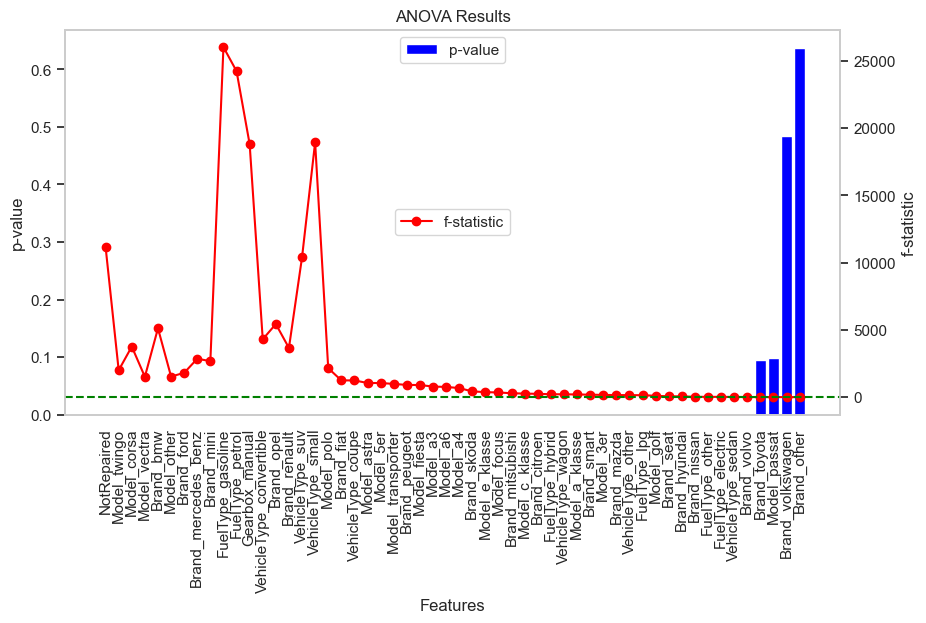

In [544]:
# Creat a function to perform ANOVA test on the categorical columns
def perform_anova(df, numerical_col, categorical_cols):

    anova_results = pd.DataFrame({'Feature': [], 'F-Statistic': [], 'p-value': []})

    for cat_col in categorical_cols:

        # Prepare the groups for ANOVA
        grouped_test2 = df[[cat_col, numerical_col]].groupby(cat_col)
        anova_data = [grouped_test2.get_group(group)[numerical_col] for group in grouped_test2.groups]

        # Perform the ANOVA test
        f_statistic, p_value = stats.f_oneway(*anova_data)

        # Store the results (without appending)
        anova_results.loc[len(anova_results)] = [cat_col, f_statistic, p_value]

    # Sort the results by p-values
    anova_results.sort_values(by=['p-value'], inplace=True)

    # Create a graph to visualize the results of ANOVA (p-values and f-statistics, sorted by p-values)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title('ANOVA Results')
    ax.set_ylabel('p-value')
    ax.set_xlabel('Features')
    ax.set_xticklabels(anova_results['Feature'], rotation=90)
    ax.bar(anova_results['Feature'], anova_results['p-value'], color='blue')
    ax.grid(False)
    ax.legend(['p-value'], loc='upper center')
    ax2 = ax.twinx()
    ax2.set_ylabel('f-statistic')
    ax2.plot(anova_results['Feature'], anova_results['F-Statistic'], color='red', marker='o')
    ax2.axhline(1, linestyle='--', color='green')
    ax2.grid(False)
    ax2.legend(['f-statistic'], loc='center')
    plt.show()

    return anova_results

# Create a list of the categorical columns
categorical_columns = df_ohe.select_dtypes(include=['uint8']).columns.tolist()

# Perform ANOVA test on the categorical columns
an_results = perform_anova(df_ohe, "Price", categorical_columns)

In [545]:
# Set threshold for p-value
p_value_threshold = 0.05

# Filter the categorical columns based on the p-value threshold
an_results = an_results[an_results["p-value"] < p_value_threshold]

# Order the categorical columns by f-statistics (descending)
an_results = an_results.sort_values(by=['F-Statistic'], ascending=False)

# Select the top 25 categorical columns based on f-statistics
selected_categorical_columns = an_results["Feature"].head(25).tolist()

# Print the selected categorical columns
print(selected_categorical_columns)

['FuelType_gasoline', 'FuelType_petrol', 'VehicleType_small', 'Gearbox_manual', 'NotRepaired', 'VehicleType_suv', 'Brand_opel', 'Brand_bmw', 'VehicleType_convertible', 'Model_corsa', 'Brand_renault', 'Brand_mercedes_benz', 'Brand_mini', 'Model_polo', 'Model_twingo', 'Brand_ford', 'Model_other', 'Model_vectra', 'Brand_fiat', 'VehicleType_coupe', 'Model_astra', 'Model_5er', 'Model_transporter', 'Brand_peugeot', 'Model_fiesta']


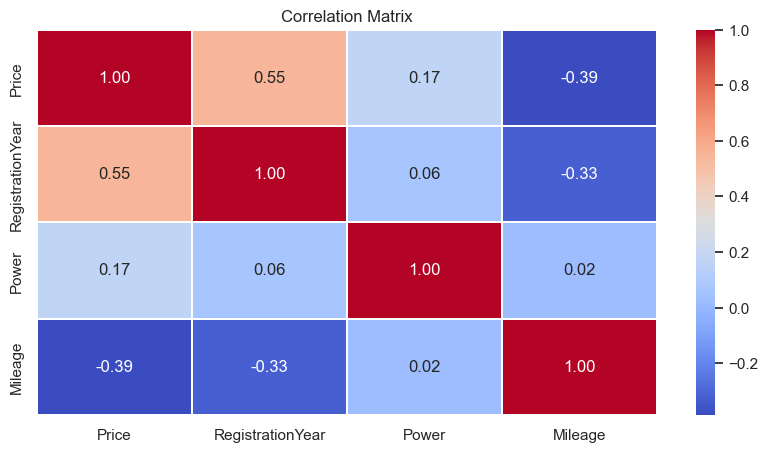

['RegistrationYear', 'Mileage', 'Power']


In [546]:
# Create a function to show a correlation matrix and a heatmap for the numerical columns
def corr_matrix_heatmap(df, numerical_cols):

    # Create the correlation matrix
    corr_matrix = df[numerical_cols].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 5))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.1, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

    # return the correlation coefficients for the target column
    return corr_matrix["Price"].sort_values(ascending=False)[1:]

# Create a list of the numerical columns
numerical_columns = df_ohe.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create a correlation matrix and a heatmap for the numerical columns
corr_results = corr_matrix_heatmap(df_ohe, numerical_columns)

# Sort the correlation coefficients by absolute values (descending)
corr_results = corr_results.abs().sort_values(ascending=False)

# Select the top 10 numerical columns based on correlation coefficients
selected_numerical_columns = corr_results.head(10).index.tolist()

# Print the selected numerical columns
print(selected_numerical_columns)

In [547]:
# Gather the selected columns
selected_columns = ["Price"] + selected_categorical_columns + selected_numerical_columns

# Filter the DataFrame with the selected columns
df_ohe = df_ohe[selected_columns]

# Print the general/summary information about the DataFrame
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284126 entries, 0 to 284125
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Price                    284126 non-null  int64
 1   FuelType_gasoline        284126 non-null  uint8
 2   FuelType_petrol          284126 non-null  uint8
 3   VehicleType_small        284126 non-null  uint8
 4   Gearbox_manual           284126 non-null  uint8
 5   NotRepaired              284126 non-null  uint8
 6   VehicleType_suv          284126 non-null  uint8
 7   Brand_opel               284126 non-null  uint8
 8   Brand_bmw                284126 non-null  uint8
 9   VehicleType_convertible  284126 non-null  uint8
 10  Model_corsa              284126 non-null  uint8
 11  Brand_renault            284126 non-null  uint8
 12  Brand_mercedes_benz      284126 non-null  uint8
 13  Brand_mini               284126 non-null  uint8
 14  Model_polo               284126 non-

### Intermediate Conclusion

- We have selected only the most relevant categorical and numerical features performing an `ANOVA` test and creating a `Correlation Matrix`.

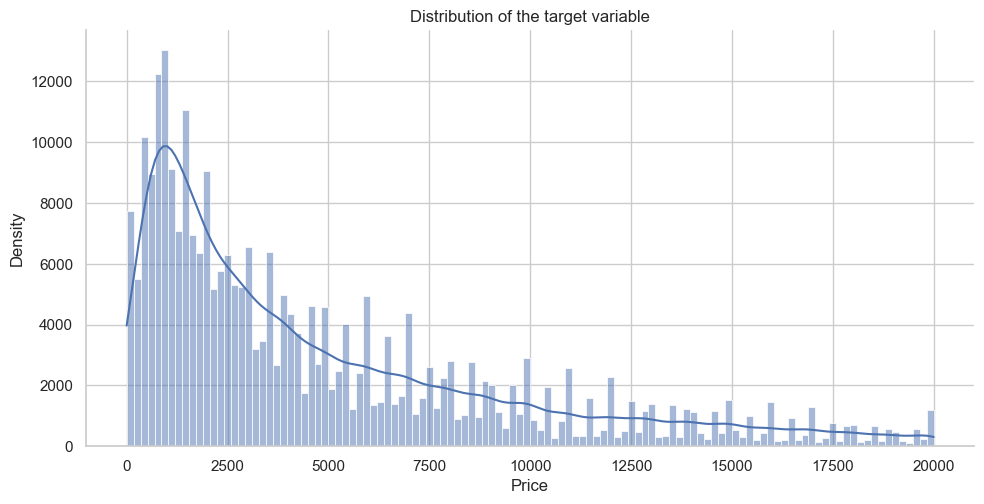

count    284126.000000
mean       4847.265516
std        4637.056831
min           0.000000
25%        1300.000000
50%        3199.000000
75%        6999.000000
max       20000.000000
Name: Price, dtype: float64

In [548]:
# Create a graph to visualize the distribution of the target variable
sns.displot(df_ohe["Price"], kde=True, height=5, aspect=2)
plt.title("Distribution of the target variable")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

# Print the descriptive statistics of the target variable
df_ohe["Price"].describe()

### Observations

- The distribution of prices is right-skewed, meaning that there are more lower-priced cars than higher-priced ones. The peak of the density appears to be somewhere around the lower price range, indicating a concentration of vehicles in the more affordable segment.
- The tail extending to the right suggests that there are some high-priced outliers in the dataset, which could significantly affect the average price and could potentially skew the results of any predictive models.

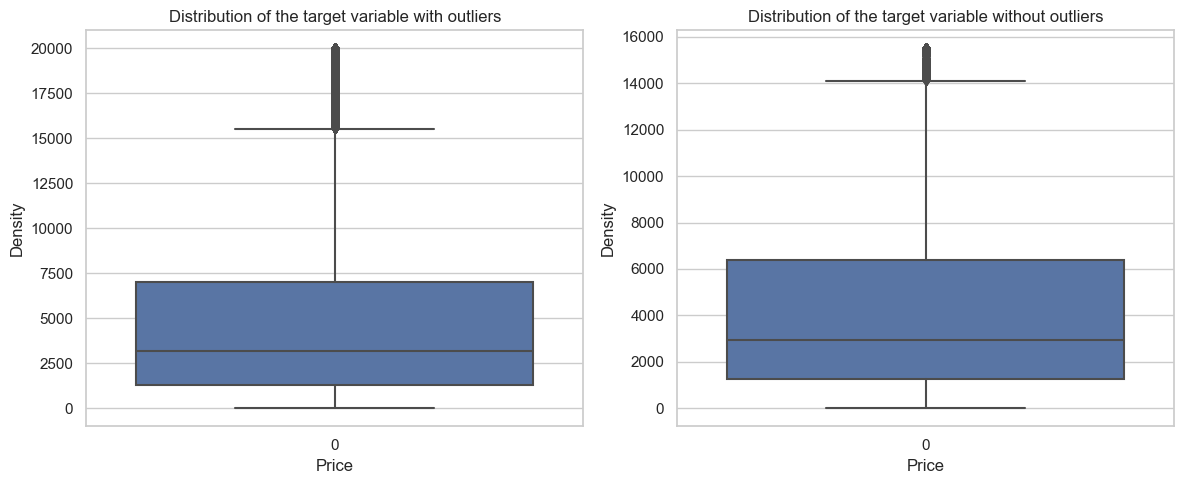

In [549]:
# Create two graphs to visualize the distribution of the target variable with and without outliers

# Create a graph to visualize the distribution of the target variable with outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df_ohe["Price"], ax=axes[0])

# Calculate the first and third quartiles
Q1 = df_ohe["Price"].quantile(0.25)
Q3 = df_ohe["Price"].quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

# Calculate the upper and lower bounds
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Get rid of the outliers
df_ohe = df_ohe[df_ohe["Price"].between(lower_bound, upper_bound)].reset_index(drop=True)

# Create a graph to visualize the distribution of the target variable without outliers
sns.boxplot(df_ohe["Price"], ax=axes[1])
axes[0].set_title("Distribution of the target variable with outliers")
axes[1].set_title("Distribution of the target variable without outliers")
axes[0].set_xlabel("Price")
axes[1].set_xlabel("Price")
axes[0].set_ylabel("Density")
axes[1].set_ylabel("Density")
plt.tight_layout()
plt.show()

### Observations

- Without outliers, the boxplot appears more symmetric, but it's important to note that the median still seems to be towards the lower end of the IQR, suggesting that even without extreme values, the distribution is not perfectly centered.

**NOTE:** We should consider using robust regression methods or tree-based models, which can be less sensitive to outliers.

## Preprocessing

In [550]:
# Scale the numerical columns
scaler = RobustScaler()
df_ohe[selected_numerical_columns] = scaler.fit_transform(df_ohe[selected_numerical_columns])

# Print the general/summary information about the DataFrame
df_ohe.info()

# Print a random sample of 5 rows from the DataFrame
df_ohe.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271699 entries, 0 to 271698
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Price                    271699 non-null  int64  
 1   FuelType_gasoline        271699 non-null  uint8  
 2   FuelType_petrol          271699 non-null  uint8  
 3   VehicleType_small        271699 non-null  uint8  
 4   Gearbox_manual           271699 non-null  uint8  
 5   NotRepaired              271699 non-null  uint8  
 6   VehicleType_suv          271699 non-null  uint8  
 7   Brand_opel               271699 non-null  uint8  
 8   Brand_bmw                271699 non-null  uint8  
 9   VehicleType_convertible  271699 non-null  uint8  
 10  Model_corsa              271699 non-null  uint8  
 11  Brand_renault            271699 non-null  uint8  
 12  Brand_mercedes_benz      271699 non-null  uint8  
 13  Brand_mini               271699 non-null  uint8  
 14  Mode

,Price,FuelType_gasoline,FuelType_petrol,VehicleType_small,Gearbox_manual,NotRepaired,VehicleType_suv,Brand_opel,Brand_bmw,VehicleType_convertible,Model_corsa,Brand_renault,Brand_mercedes_benz,Brand_mini,Model_polo,Model_twingo,Brand_ford,Model_other,Model_vectra,Brand_fiat,VehicleType_coupe,Model_astra,Model_5er,Model_transporter,Brand_peugeot,Model_fiesta,RegistrationYear,Mileage,Power
259586,10500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.571429,-5.6,-0.279412
37779,2000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.428571,0.0,-0.014706
158241,5000,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-4.571429,-2.8,0.382353
31375,1549,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.142857,0.0,-0.661765
96513,1950,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.571429,0.0,-1.544118


# Model construction

In [551]:
# Set random seed for reproducibility
random_state = 12345

## Data Segmentation

In [552]:
# Split the training and test sets into features and target
features_ohe = df_ohe.drop("Price", axis=1)
target_ohe = df_ohe["Price"]

# Split the data into training and test sets
train_features_ohe, test_features_ohe, train_target_ohe, test_target_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=random_state
)

## Find the best hyperparameters

In [553]:
# Set the scoring metric to be used for choosing the best hyperparameters
scoring = 'neg_mean_absolute_error'

In [554]:
# Create a function to calculate the best hyperparameters for a list of models
def find_best_params(models, train_features, train_target, scoring):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best Score'])

    # Iterate through the list of models
    for model in models:
        # Print the name of the model
        print(f"Finding best parameters for {type(model['model']).__name__}...")

        # Perform a grid search of the hyperparameters
        grid = GridSearchCV(model['model'], model['param_grid'], cv=5, scoring=scoring, verbose=0, n_jobs=-1)
        grid.fit(train_features, train_target)

        # Extract best parameters and score
        best_params = grid.best_params_
        best_score = np.abs(grid.best_score_)

        # Store the results in the DataFrame
        results = pd.concat([results, pd.DataFrame({'Model': type(model['model']).__name__, 
                                  'Best Parameters': [best_params], 
                                  'Best Score': best_score})], ignore_index=True)

        # Sort the DataFrame by best score
        results.sort_values(by='Best Score', ascending=False, inplace=True)

    # Create a bar plot to visualize the best scores
    plt.figure(figsize=(12, 10))
    sns.barplot(data=results, x='Model', y='Best Score', palette="coolwarm")
    plt.title("Grid Search Results")
    plt.xticks(rotation=45)
    plt.tight_layout()

    return results

Finding best parameters for LinearRegression...
Finding best parameters for CatBoostRegressor...
Finding best parameters for XGBRegressor...


,Model,Best Parameters,Best Score
0,LinearRegression,{},1824.920166
1,CatBoostRegressor,"{'depth': 14, 'iterations': 200}",970.020870
2,XGBRegressor,"{'max_depth': 10, 'n_estimators': 150}",967.708811


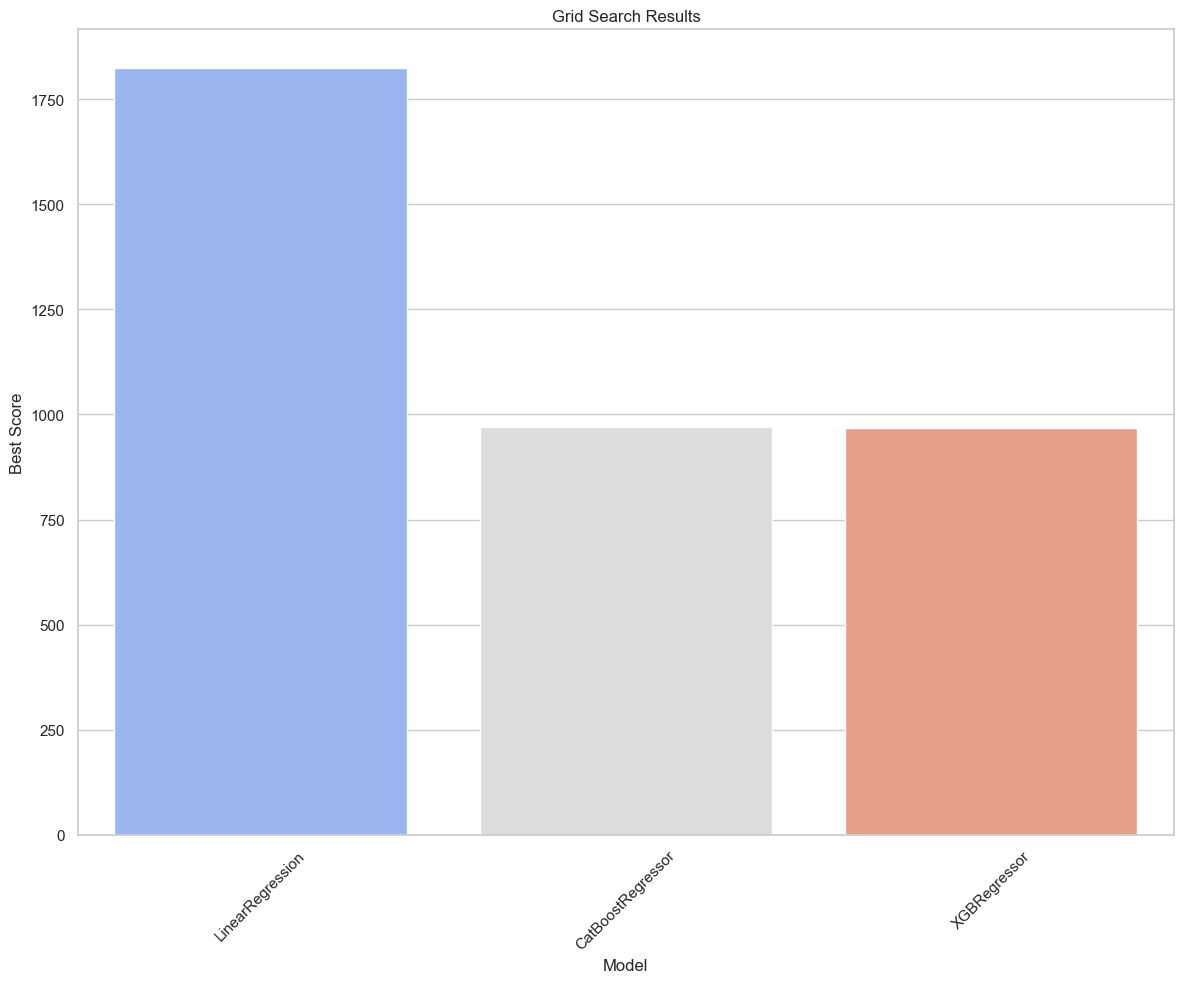

In [555]:
# Define the models and their hyperparameters
models = [
    {
        'model': LinearRegression(),
        'param_grid': {}
    },
    {
        'model': CatBoostRegressor(random_state=random_state, verbose=False),
        'param_grid': {'iterations': np.arange(50, 201, 50), 'depth': np.arange(3, 15)}
    },
    {
        'model': XGBRegressor(random_state=random_state, verbosity=0),
        'param_grid': {'n_estimators': np.arange(50, 201, 50), 'max_depth': np.arange(3, 15)}
    },
]

# Find the best hyperparameters for each model
results = find_best_params(models, train_features_ohe, train_target_ohe, scoring)

# Print the results
results

In [556]:
# Set the index of the DataFrame to the model name
results.set_index('Model', inplace=True)

# Set the hyperparameters for each model based on the results of the grid search
models = [
    LinearRegression(**results.loc['LinearRegression']['Best Parameters']),
    CatBoostRegressor(random_state=random_state, **results.loc['CatBoostRegressor']['Best Parameters'], silent=True),
    XGBRegressor(random_state=random_state, **results.loc['XGBRegressor']['Best Parameters'], verbosity=0)
]

## Train and evaluate models

In [557]:
# Create a function to train and evaluate multiple models on the training and validation subsets and create a graph to visualize the results
def train_and_evaluate_models(models, train_features, train_target, test_features, test_target):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'RMSE', 'R2', 'Training time', 'Prediction time'])
    
    # Loop through each model
    for model in models:
        # Train the model
        start = time.time()
        model.fit(train_features, train_target)
        end = time.time()
        train_time = end - start

        # Make predictions
        start = time.time()
        predictions = model.predict(test_features)
        end = time.time()
        test_time = end - start

        # Calculate the metrics
        rmse = math.sqrt(mean_squared_error(test_target, predictions))
        r2 = r2_score(test_target, predictions)

        # Append the results to the DataFrame
        results = pd.concat([results, pd.DataFrame({'Model': model.__class__.__name__, 'RMSE': rmse, 'R2': r2, 'Training time': train_time, 'Prediction time': test_time}, index=[0])], ignore_index=True)
    
    # Draw a heatmap to visualize the results
    plt.figure(figsize=(14,7))
    sns.set(style="whitegrid")
    sns.heatmap(results.set_index('Model'), annot=True, cmap='RdBu_r')
    plt.title('Model Comparison')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

    return results

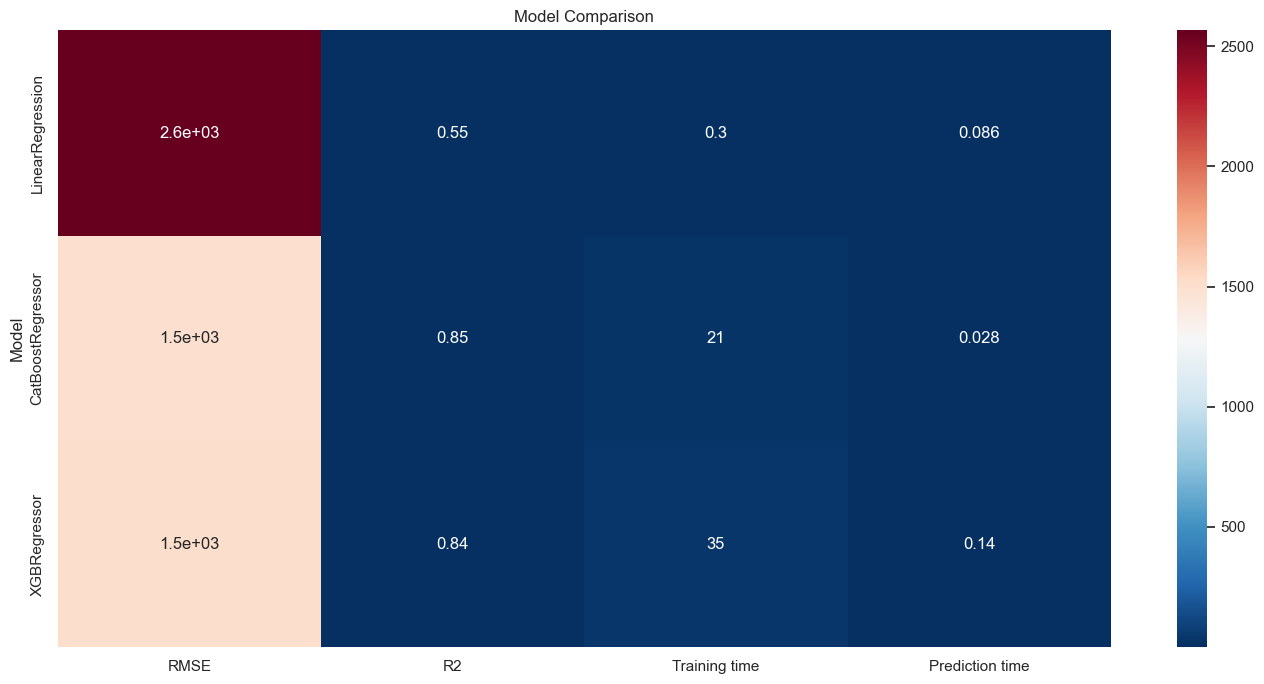

,Model,RMSE,R2,Training time,Prediction time
0,LinearRegression,2566.636221,0.546933,0.295315,0.085720
1,CatBoostRegressor,1498.851795,0.845492,20.765227,0.027651
2,XGBRegressor,1508.246181,0.843549,35.470776,0.141927


In [558]:
# Train and evaluate the models
results = train_and_evaluate_models(models, train_features_ohe, train_target_ohe, test_features_ohe, test_target_ohe)

# Print the results
results

## Intermediate Conclusion

`CatBoost` appears to be the most efficient model, providing the lowest RMSE score, highest R2 value and the second lowest training and prediction times compared to the other models.

# General Conclusion

During this project for the second-hand car sales service at `Rusty Bargain`:

1. We have cleaned and imputed data, focusing on the variable `Model` to improve data quality.

2. We implemented and compared several regression models (Linear Regression, CatBoost, and XGBoost) to predict the market value of used vehicles. The gradient boosting models (CatBoost and XGBoost) showed superior performance.

3. We improved the accuracy of the models by adjusting hyperparameters, achieving a balance between accuracy and efficiency.

4. We chose the `CatBoost` model based on the results of the `RMSE` and `R2` metrics, as well as the training time and prediction time.

In summary, we have developed a model that can accurately predict the market value of used vehicles, providing a valuable tool for Rusty Bargain and highlighting the importance of careful data handling and a balanced consideration between model accuracy and efficiency.